In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from scipy import integrate
import numpy as np
import jax
import jax.numpy as jnp

from dosipy.constants import eps_0
from dosipy.field import poynting
from dosipy.utils.dataloader import (load_tissue_diel_properties,
                                     load_antenna_el_properties)
from dosipy.utils.integrate import elementwise_quad, elementwise_rectquad
from dosipy.utils.derive import holoborodko

from utils import reflection_coefficient

In [2]:
sns.set_theme(style='ticks',
              font_scale=1.5,
              palette='colorblind',
              rc={'text.usetex': True,
                  'text.latex.preamble': r'\usepackage{amsmath}',
                  'font.family': 'serif'})

# Penetration depth analysis

In [53]:
# frequencies in Hz
f = np.array([1, 2, 5, 10, 20, 50, 100]) * 1e9  

# load the dielectric data for dry skin
sigma, eps_r, _, penetration_depth = np.vectorize(
    load_tissue_diel_properties
    )('skin_dry', f)

# compute the power transmission coefficient
eps_i = sigma / (2 * np.pi * f * eps_0)
eps = eps_r - 1j * eps_i
gamma = reflection_coefficient(eps)
T_tr = 1 - gamma ** 2

ValueError: x and y must have same first dimension, but have shapes (1,) and (7,)

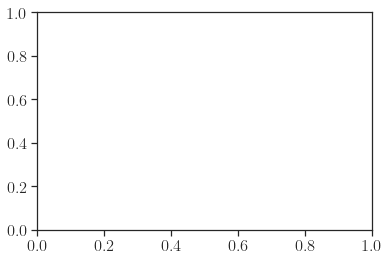

In [71]:
# visualize
cs = sns.color_palette('colorblind', 2)
fig, ax1 = plt.subplots()
ax1.plot(f / 1e9, penetration_depth * 1000, 'o-', lw=3, ms=7, c=cs[0],
         label='penetration\ndepth')
ax1.tick_params(axis='y', labelcolor=cs[0])
ax1.set(
    xscale='log',
    xlabel='frequency [GHz]',
    ylabel='penetration depth (mm)',
    yticks=[0, 25, 50],
    yticklabels=[0, 25, 50],
    )
ax1.legend(loc='upper left', frameon=False)
ax2 = ax1.twinx()
ax2.plot(f / 1e9, np.abs(T_tr), 's--',lw=3, ms=7, c=cs[1],
        label='transmission\ncoefficient')
ax2.tick_params(axis='y', labelcolor=cs[1])
ax2.set(
    xscale='log',
    ylabel='transmission coefficient',
    xticks=[1, 10, 100],
    xticklabels=[1, 10, 100],
    yticks=[0.4, 0.6, 0.8],
    yticklabels=[0.4, 0.6, 0.8],
    ylim=[0.385, 0.8]
    )
ax2.legend(loc='upper right', frameon=False)
fig.tight_layout()
plt.show()

# Current across the dipole in free space

## Input data

In [65]:
# working frequency, Hz
f = 30e9

# dry skin density, kg/m3
rho = 1109

# conductivity, relative permitivitya and penetration depth
sigma, eps_r, _, pen_depth = load_tissue_diel_properties('skin_dry', f)

# reflection coefficient
eps_i = sigma / (2 * np.pi * f * eps_0)
eps = eps_r - 1j * eps_i
gamma = reflection_coefficient(eps)

# power transmission coefficient
T_tr = 1 - gamma ** 2

## Solution domain setup

In [66]:
# exposed surface extent
if f <= 30e9:
    exposure_extent = (0.02, 0.02)  # meters x meters
else:
    exposure_extent = (0.01, 0.01)  # meters x meters

# exposed surface area
A = exposure_extent[0] * exposure_extent[1]  # meters^2

# exposed volume coordinates
xt = jnp.linspace(-exposure_extent[0]/2, exposure_extent[0]/2)
yt = jnp.linspace(-exposure_extent[1]/2, exposure_extent[1]/2)
Xt, Yt = np.meshgrid(xt, yt)
z_max = 0.02  # in meters
zt = jnp.linspace(0, z_max)

# distance from the antenna
h = 5 / 1000  # meters

## Dipole positioning

In [67]:
# antenna electric properties, free space (Poljak 2005)
antenna_data = load_antenna_el_properties(f)

# antenna position - coordinates
xs = antenna_data.x.to_numpy()
xs = xs - xs.max() / 2
xs = jnp.asarray(xs)
ys = jnp.zeros_like(xs)
zs = jnp.full_like(xs, h)

# current through the antenna
Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j

# current gradients
Is_x = holoborodko(Is, xs[1]-xs[0])

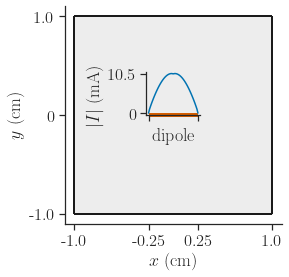

In [68]:
fig, ax = plt.subplots()
width = (np.ptp(xs) / np.ptp(xt) * 100).item()
axin = inset_axes(ax, width=f'{width}%', height='20%', loc='center',
                  bbox_to_anchor=(0, 0.1, 1, 1), bbox_transform=ax.transAxes)

# main axes, exposed surface
bbox = [xt.min(), xt.max(), yt.min(), yt.max()]
xmin, xmax = bbox[:2]
ymin, ymax = bbox[2:]
ax.vlines(x=bbox[:2], ymin=ymin, ymax=ymax,
          color='k', lw=2)
ax.hlines(y=bbox[2:], xmin=xmin, xmax=xmax,
          color='k', lw=2)
ax.fill_between(x=bbox[:2], y1=ymin, y2=ymax, color='k', alpha=0.075)
ax.hlines(y=ys[0], xmin=xs.min(), xmax=xs.max(),
          color='r', lw=4)
ax.set_aspect('equal', 'box')
ax.set(xlabel='$x$ (cm)',
       ylabel='$y$ (cm)',
       xticks=[xmin, xs.min(), xs.max(), xmax],
       yticks=[ymin, 0, ymax],
       xticklabels=[xmin * 100,
                    np.round(xs.min() * 100, 2),
                    np.round(xs.max() * 100, 2),
                    xmax * 100],
       yticklabels=[ymin * 100, 0, ymax * 100])
sns.despine(fig=fig, ax=ax)

# inserted axes, antenna position relative to surface
axin.plot(xs, np.abs(Is))
axin.set(xlabel='dipole',
         ylabel='$|I|$ (mA)',
         xticks=[xs.min(), xs.max()],
         yticks=[0, np.abs(Is).max()],
         xticklabels=[],
         yticklabels=[0, np.round(np.abs(Is).max() * 1000, 1)])
axin.patch.set_alpha(0)

# EM field distribution in free space

In [37]:
# incident PD components on the exposed surface
PDinc = np.empty((xt.size, yt.size, 3), dtype=np.complex128)
for xi, _xt in enumerate(xt):
    for yi, _yt in enumerate(yt):
        PDinc[xi, yi, :] = poynting(_xt, _yt, zt[0], xs, ys, zs, f, Is, Is_x)

In [38]:
# averaged total incident power density on the surface
PDinc_tot = np.abs(np.sqrt(PDinc[:, :, 0] ** 2
                           + PDinc[:, :, 1] ** 2
                           + PDinc[:, :, 2] **2))
sPDinc_tot = 1 / (2 * A) * elementwise_rectquad(xt, yt, PDinc_tot)

# averaged normal incident power density on the surface
PDinc_n = np.abs(PDinc[:, :, 2].real)
sPDinc_n = 1 / (2 * A) * elementwise_rectquad(xt, yt, PDinc_n)

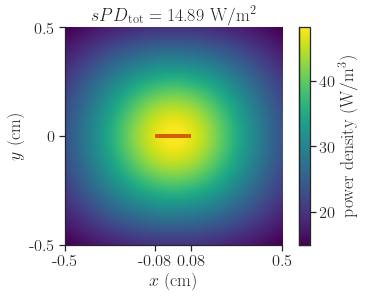

In [67]:
fig, ax = plt.subplots()
cm = ax.imshow(PDinc_tot,
               extent=bbox,
               origin='lower',
               interpolation='bicubic',
               cmap='viridis')
cb = fig.colorbar(cm, ax=ax,
                  label='power density (W$/$m$^3$)')
ax.hlines(y=ys[0], xmin=xs.min(), xmax=xs.max(),
          color='r', lw=4)
ax.set(xlabel='$x$ (cm)',
       ylabel='$y$ (cm)',
       xticks=[xmin, xs.min(), xs.max(), xmax],
       yticks=[ymin, 0, ymax],
       xticklabels=[xmin * 100,
                    np.round(xs.min() * 100, 2),
                    np.round(xs.max() * 100, 2),
                    xmax * 100],
       yticklabels=[ymin * 100, 0, ymax * 100],
       title=f'$sPD_\\text{{tot}}$ = {sPDinc_tot:.2f} W$/$m$^2$')
sns.despine(fig=fig, ax=ax)

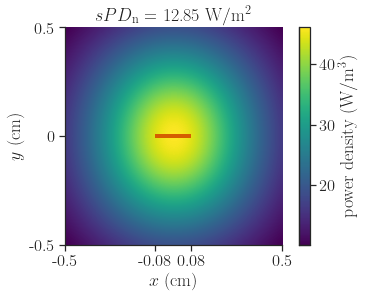

In [68]:
fig, ax = plt.subplots()
cm = ax.imshow(PDinc_n,
               extent=bbox,
               origin='lower',
               interpolation='bicubic',
               cmap='viridis')
cb = fig.colorbar(cm, ax=ax,
                  label='power density (W$/$m$^3$)')
ax.hlines(y=ys[0], xmin=xs.min(), xmax=xs.max(),
          color='r', lw=4)
ax.set(xlabel='$x$ (cm)',
       ylabel='$y$ (cm)',
       xticks=[xmin, xs.min(), xs.max(), xmax],
       yticks=[ymin, 0, ymax],
       xticklabels=[xmin * 100,
                    np.round(xs.min() * 100, 2),
                    np.round(xs.max() * 100, 2),
                    xmax * 100],
       yticklabels=[ymin * 100, 0, ymax * 100],
       title=f'$sPD_\\text{{n}}$ = {sPDinc_n:.2f} W$/$m$^2$')
sns.despine(fig=fig, ax=ax)

# Spatially averaged abosorbed power density

In [69]:
# via the magnitude defintion
sPDab_tot = T_tr * sPDinc_tot
sPDab_tot

10.184089786005888

In [70]:
# via the normal defintion
sPDab_n = T_tr * sPDinc_n
sPDab_n

8.789238780893994